In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN

from utils import env
from dataset.image import Image

from jupyterthemes import jtplot
jtplot.style('onedork')
jt_colors = ['#ea8080', '#61afef', '#94c273', '#fea47f', '#DDD7A3', '#e07a7a', '#cc89e0', '#51b6c3', '#6a737d'] #red blue green orange yellow magenta violet cyan grey
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'magenta', 'violet', 'cyan', 'white', 'pink', 'turquoise', 'olive', 'lime', 'sienna' ,'black']

# Global parameters

In [2]:
IMG_PATH = os.path.join(env.VALID_PATH, 'images', '0000069_00483_d_0000002.jpg')
H = 1750 # mm
FOCAL_LENGTHS = [75, 100, 125, 150] # mm

# Reading data

In [3]:
image = Image(IMG_PATH)
objects = image.read_annotations(subset=['left', 'top', 'width', 'height'])
objects['x'] = objects['left'] + objects['width']//2 - image.width//2
objects['y'] = objects['top'] + objects['height']
objects = objects.drop(columns=['left', 'top'])
objects = objects[['x', 'y', 'width', 'height']]

objects.head()

,x,y,width,height
0,105,675,55,165
1,83,626,51,137
2,97,449,47,114
3,-236,80,18,60
4,-231,81,16,62


# Height distribution

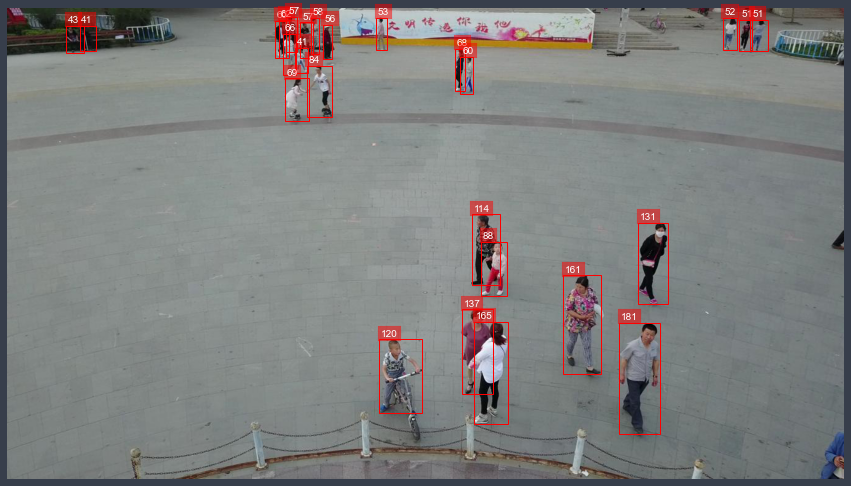

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
image.show(ax=ax)
for x, y, width, height in objects.values:
    left, top = x + image.width//2 - width//2, y - height
    rect = Rectangle((left, top), width, height, linewidth=1, edgecolor='red', facecolor='none')
    ax.annotate(str(height), (left + 3, top - 6), color='white', bbox=dict(boxstyle='square', fc='red', ec='red', alpha=.5), size=10)
    ax.add_patch(rect)
ax.grid(False)

# Smoothing height distribution

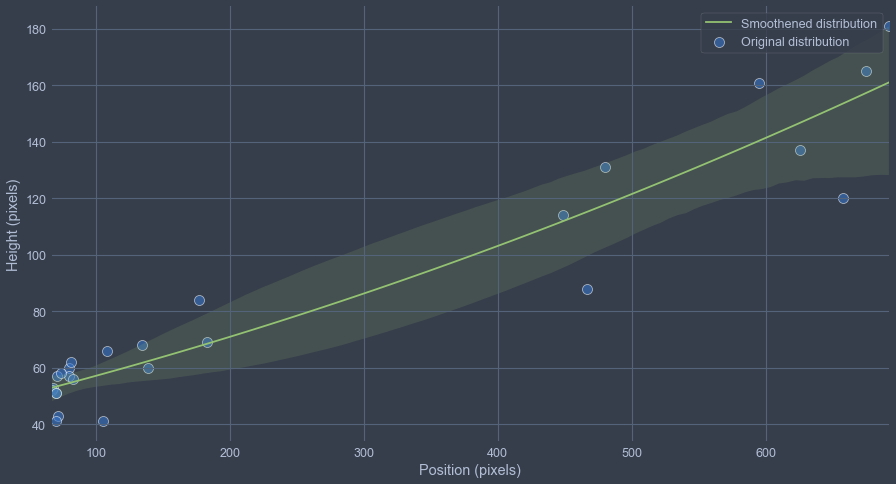

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=objects, x='y', y='height', s=100, alpha=.6, ax=ax, label='Original distribution')
sns.regplot(data=objects, x='y', y='height', ax=ax, order=2, scatter=False, label='Smoothened distribution', color=jt_colors[2])
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True, labeltop = False, labelleft = True, labelright = False)
ax.set_xlabel('Position (pixels)')
ax.set_ylabel('Height (pixels)')
ax.legend()
for spine in ax.spines.values():
    spine.set_visible(False)

In [6]:
objects = objects.sort_values(by = 'y')
poly = PolynomialFeatures(degree = 2)
X = poly.fit_transform(objects.iloc[:, 1:2])
reg = LinearRegression().fit(X, objects['height'].values)

objects['sm_height'] = reg.predict(poly.transform(objects.iloc[:, 1:2]))

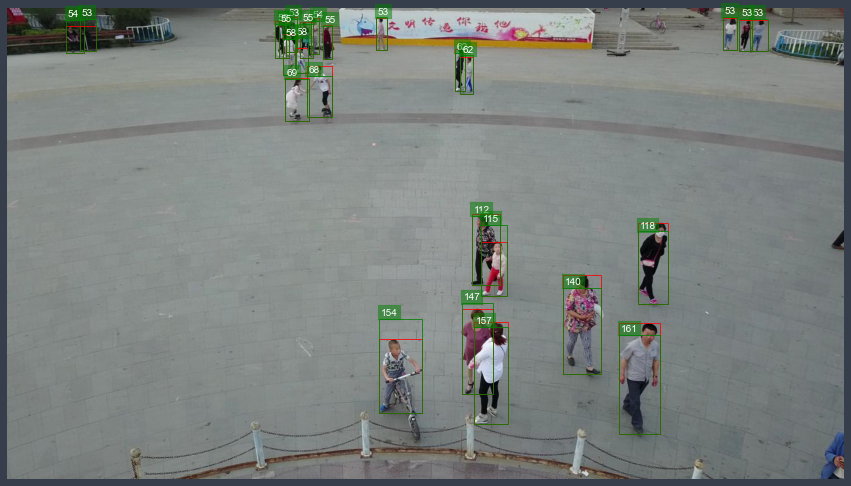

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
image.show(ax=ax)
for x, y, width, height, sm_height in objects.values:
    left, sm_top, top = x + image.width//2 - width//2, y - sm_height, y - height
    rect1 = Rectangle((left, top), width, height, linewidth=1, edgecolor='red', alpha=.8, facecolor='none')
    rect2 = Rectangle((left, sm_top), width, sm_height, linewidth=1, edgecolor='green', alpha=.8, facecolor='none')
    ax.annotate(str(round(sm_height)), (left + 3, sm_top - 6), color='white', bbox=dict(boxstyle='square', fc='green', ec='green', alpha=.5), size=10)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
ax.grid(False)

# Converting pixel scale to a metric scale
$$
\Large
\begin{align}
    25.4\ \text{mm} &\rightarrow& 96\ \text{pixels}\\
    ?\ \text{mm} &\rightarrow& X\ \text{pixels}
\end{align}
$$

In [8]:
convert = lambda x: (x*25.4)/96

objects_ = objects.copy()
objects_ = objects_.apply(convert)

objects_.head()

,x,y,width,height,sm_height
16,130.439583,17.727083,6.085417,13.758333,14.007093
13,-19.314583,17.991667,4.497917,14.022917,14.040316
26,-145.520833,18.520833,7.143750,10.847917,14.106881
18,143.139583,18.520833,7.408333,13.493750,14.106881
17,137.318750,18.520833,5.556250,13.493750,14.106881


# Distance projection
$$
    \Large
    L'A = \frac{|A|}{|A'|}{f} = \frac{H}{|A'|}{f}
$$
$$
    \Large
    O_1A = \frac{OA'\times y}{f}
$$

In [9]:
objects_['y'] = convert(image.height) - objects_['y']
for f in FOCAL_LENGTHS:
    objects_['y (f = {})'.format(f)] = H*f/objects_['sm_height']
    objects_['x (f = {})'.format(f)] = objects_['x']*objects_['y (f = {})'.format(f)]/f
objects_.head()

,x,y,width,height,sm_height,y (f = 75),x (f = 75),y (f = 100),x (f = 100),y (f = 125),x (f = 125),y (f = 150),x (f = 150)
16,130.439583,184.679167,6.085417,13.758333,14.007093,9370.252687,16296.691416,12493.670249,16296.691416,15617.087811,16296.691416,18740.505374,16296.691416
13,-19.314583,184.414583,4.497917,14.022917,14.040316,9348.080466,-2407.390389,12464.107289,-2407.390389,15580.134111,-2407.390389,18696.160933,-2407.390389
26,-145.520833,183.885417,7.143750,10.847917,14.106881,9303.969841,-18052.285927,12405.293121,-18052.285927,15506.616401,-18052.285927,18607.939681,-18052.285927
18,143.139583,183.885417,7.408333,13.493750,14.106881,9303.969841,17756.884884,12405.293121,17756.884884,15506.616401,17756.884884,18607.939681,17756.884884
17,137.318750,183.885417,5.556250,13.493750,14.106881,9303.969841,17034.793447,12405.293121,17034.793447,15506.616401,17034.793447,18607.939681,17034.793447


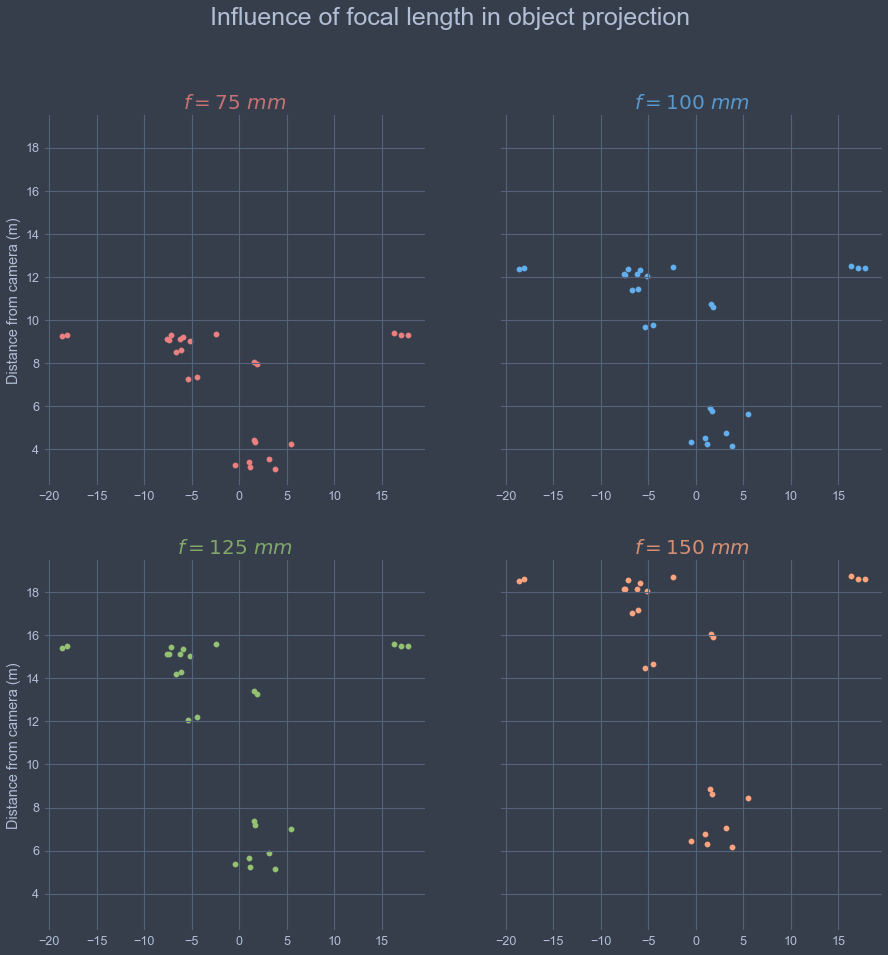

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(15, 15))
fig.suptitle('Influence of focal length in object projection', fontsize=25)
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.scatter(
        objects_['x (f = {})'.format(FOCAL_LENGTHS[i])].apply(lambda y: y/1000), 
        objects_['y (f = {})'.format(FOCAL_LENGTHS[i])].apply(lambda y: y/1000), 
        color=jt_colors[i])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(
        bottom = False, top = False, left = False, right = False, 
        labelbottom = True, labeltop = False, labelleft = True if i%2==0 else False, labelright = False
    )
    ax.set_ylabel('Distance from camera (m)') if i%2 == 0 else ax.set_ylabel('')
    ax.grid(True)
    ax.set_title('$f = y0\ mm$'.replace('y0', str(FOCAL_LENGTHS[i])), color=jt_colors[i], alpha=.8, fontdict={'fontsize': 20})

# Clustering

In [11]:
models = []
for f in FOCAL_LENGTHS:
    models.append(DBSCAN(eps = 2000, min_samples = 3).fit(objects_[['y (f = {})'.format(FOCAL_LENGTHS[i]), 'x (f = {})'.format(FOCAL_LENGTHS[i])]].values))

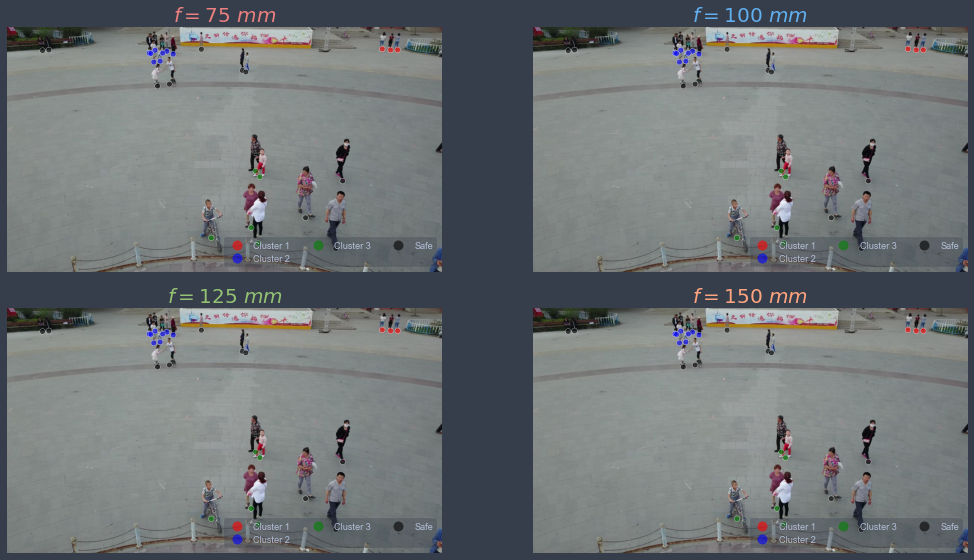

In [12]:
tmp = objects.copy()
tmp['x'] = tmp['x'] + image.width//2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(15, 8))
fig.tight_layout()
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    map_colors = [colors[i] for i in models[i].labels_]
    image.show(ax=ax)
    sns.scatterplot(data = tmp, x = 'x', y = 'y', ax=ax, c=map_colors, alpha=.6)
    ax.set_title('$f = y0\ mm$'.replace('y0', str(FOCAL_LENGTHS[i])), color=jt_colors[i], fontdict={'fontsize': 20})
    ax.grid(False)
    ax.legend(handles=[
        Line2D([0], [0], marker='o', color=colors[k], lw=0, label='Safe' if k == -1 else 'Cluster {}'.format(k + 1), markersize=10, alpha=.6) for k in set(models[i].labels_)
    ], loc='lower right', fontsize='x-small', framealpha=.3, ncol=3)